In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
# tf_flowers 데이터 가져오기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [64]:
# 데이터 셋 확인
print(raw_train)
print(raw_validation)
print(raw_test)


<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

	"       - 'Nanum'
"
	in file "/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"


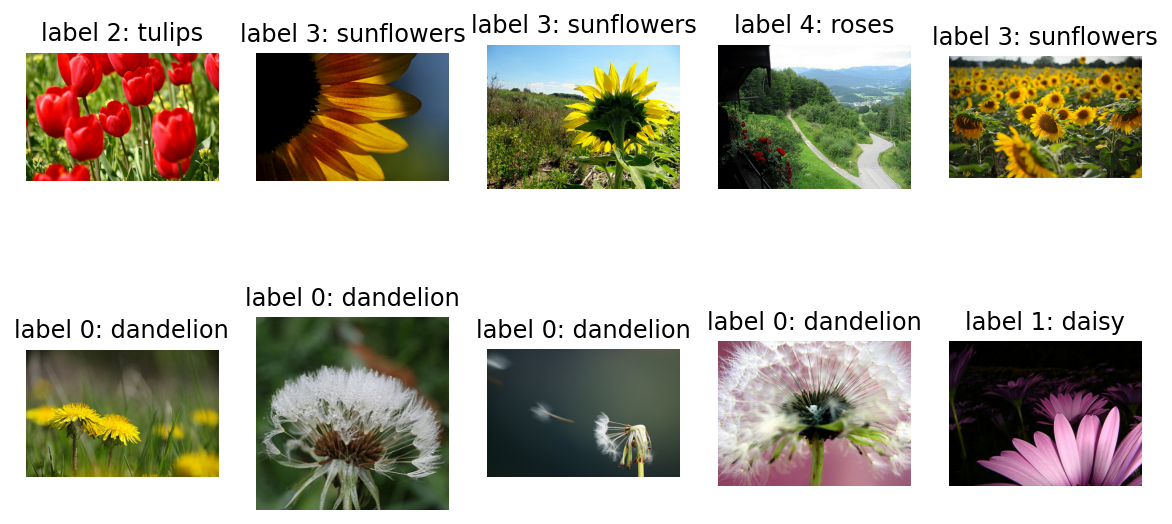

In [6]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [7]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
# map함수로 train, validataion, test 데이터셋 변환

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

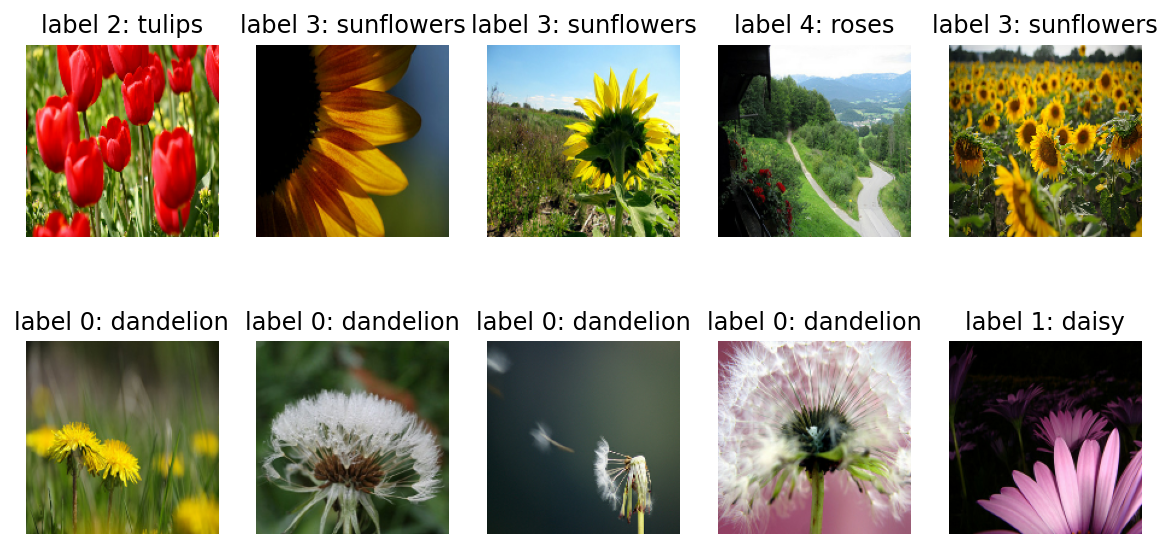

In [9]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [10]:
# 텐서플로우로 모델 구조 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [11]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')        # class 변경
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [12]:
# 모델 compile 완료 후 학습시키기

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000

In [14]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([10, 160, 160, 3]), TensorShape([10]))

In [16]:
# 초기 모델 성능 확인 ,validation_batches
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 5ms/step - loss: 1.6216 - accuracy: 0.1850
initial loss: 1.62
initial accuracy: 0.19


In [17]:
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
294/294 [==============================] - 20s 68ms/step - loss: 1.2360 - accuracy: 0.4779 - val_loss: 1.0717 - val_accuracy: 0.5450
Epoch 2/5
294/294 [==============================] - 4s 13ms/step - loss: 0.9558 - accuracy: 0.6253 - val_loss: 1.0656 - val_accuracy: 0.5858
Epoch 3/5
294/294 [==============================] - 4s 13ms/step - loss: 0.7900 - accuracy: 0.7074 - val_loss: 0.9374 - val_accuracy: 0.6431
Epoch 4/5
294/294 [==============================] - 4s 13ms/step - loss: 0.6420 - accuracy: 0.7657 - val_loss: 0.9457 - val_accuracy: 0.6185
Epoch 5/5
294/294 [==============================] - 4s 13ms/step - loss: 0.4937 - accuracy: 0.8273 - val_loss: 1.0247 - val_accuracy: 0.6131


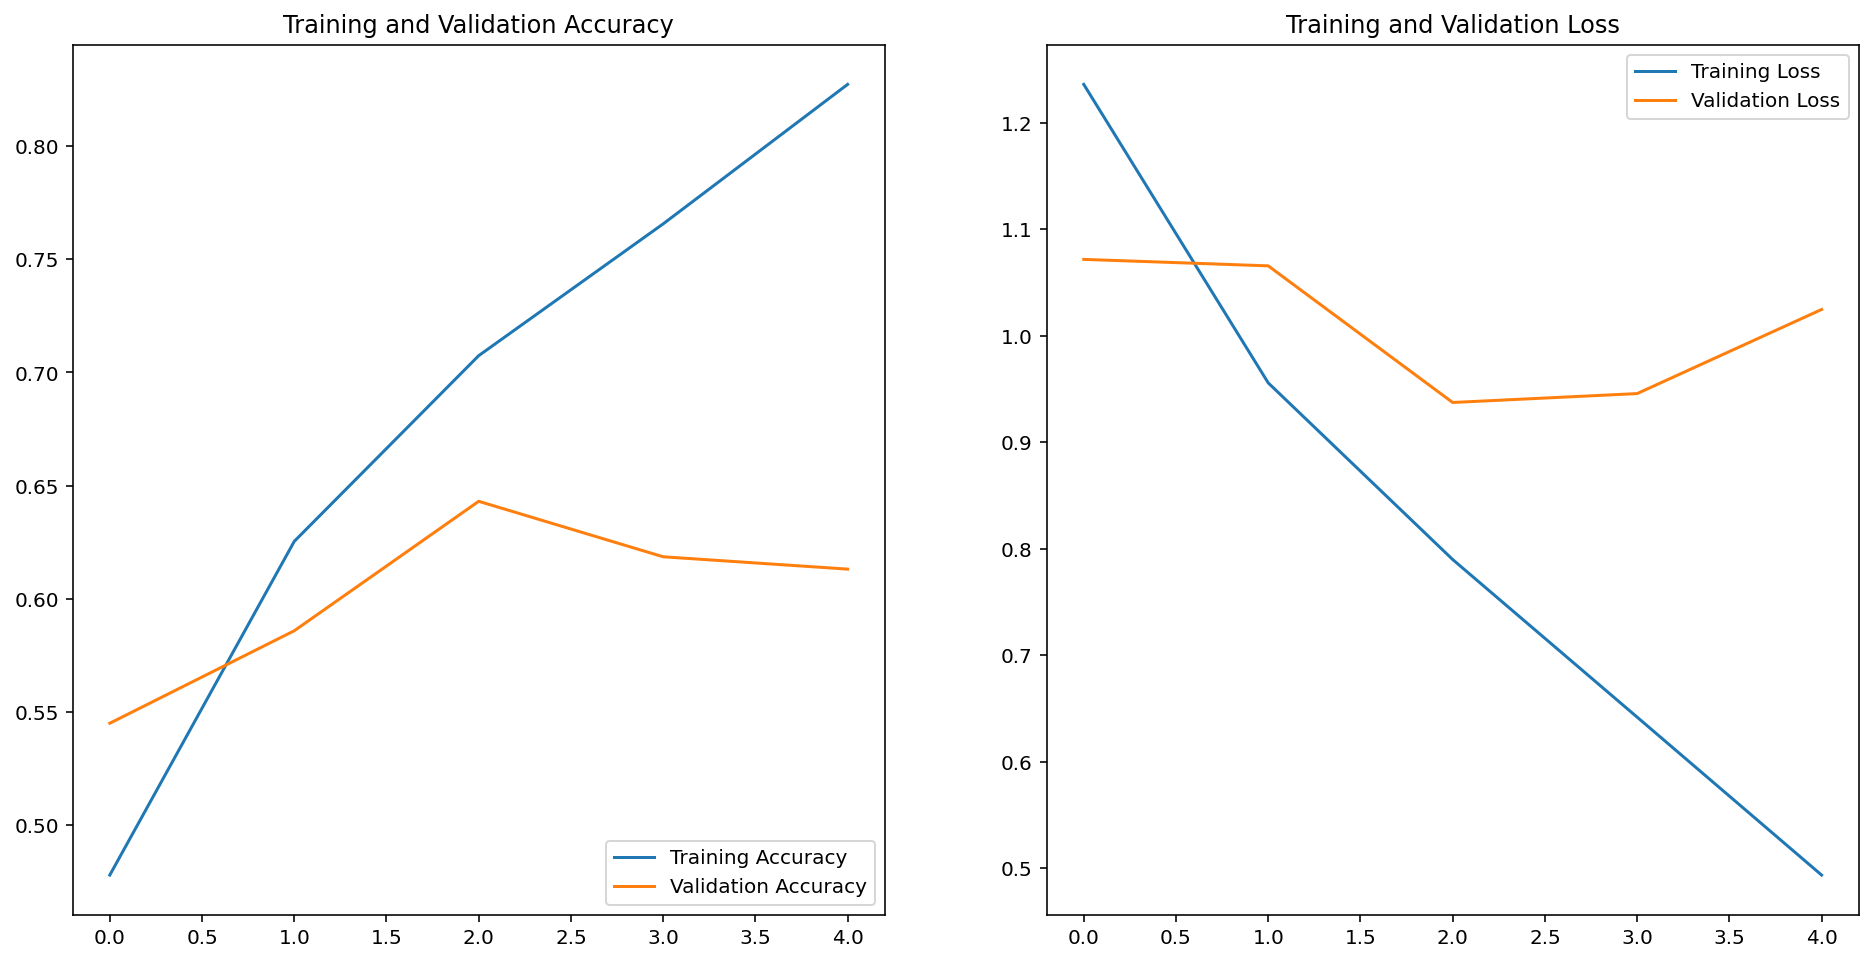

In [18]:
# 모델 학습곡선 확인 및 예측 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# 모델 결과 예측

for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.57182028e-02, 8.01849440e-02, 1.58058301e-01, 3.67618978e-01,
        3.68419558e-01],
       [3.78742963e-01, 6.17303491e-01, 7.51869520e-04, 1.00163641e-04,
        3.10152583e-03],
       [7.40431488e-01, 5.01219518e-02, 2.22969316e-02, 1.84491873e-01,
        2.65777041e-03],
       [1.08901888e-01, 5.91828108e-01, 1.61827073e-01, 6.77081756e-03,
        1.30672097e-01],
       [7.73188353e-01, 1.45917863e-01, 1.05839958e-02, 1.13254664e-02,
        5.89842908e-02],
       [4.77016926e-01, 3.66013736e-01, 2.64728628e-02, 1.45902624e-02,
        1.15906179e-01],
       [6.73042471e-03, 5.70245564e-01, 3.27686727e-01, 3.07867769e-02,
        6.45504743e-02],
       [8.69602636e-02, 3.23928863e-01, 7.59285763e-02, 2.53340155e-01,
        2.59842187e-01],
       [5.01349708e-03, 1.40042001e-04, 1.71265122e-03, 9.92951810e-01,
        1.81953059e-04],
       [8.87203455e-01, 1.10671215e-01, 2.39338478e-04, 2.69545213e-04,
        1.61635468e-03]], dtype=float32)

In [20]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([4, 1, 0, 1, 0, 0, 1, 1, 3, 0])

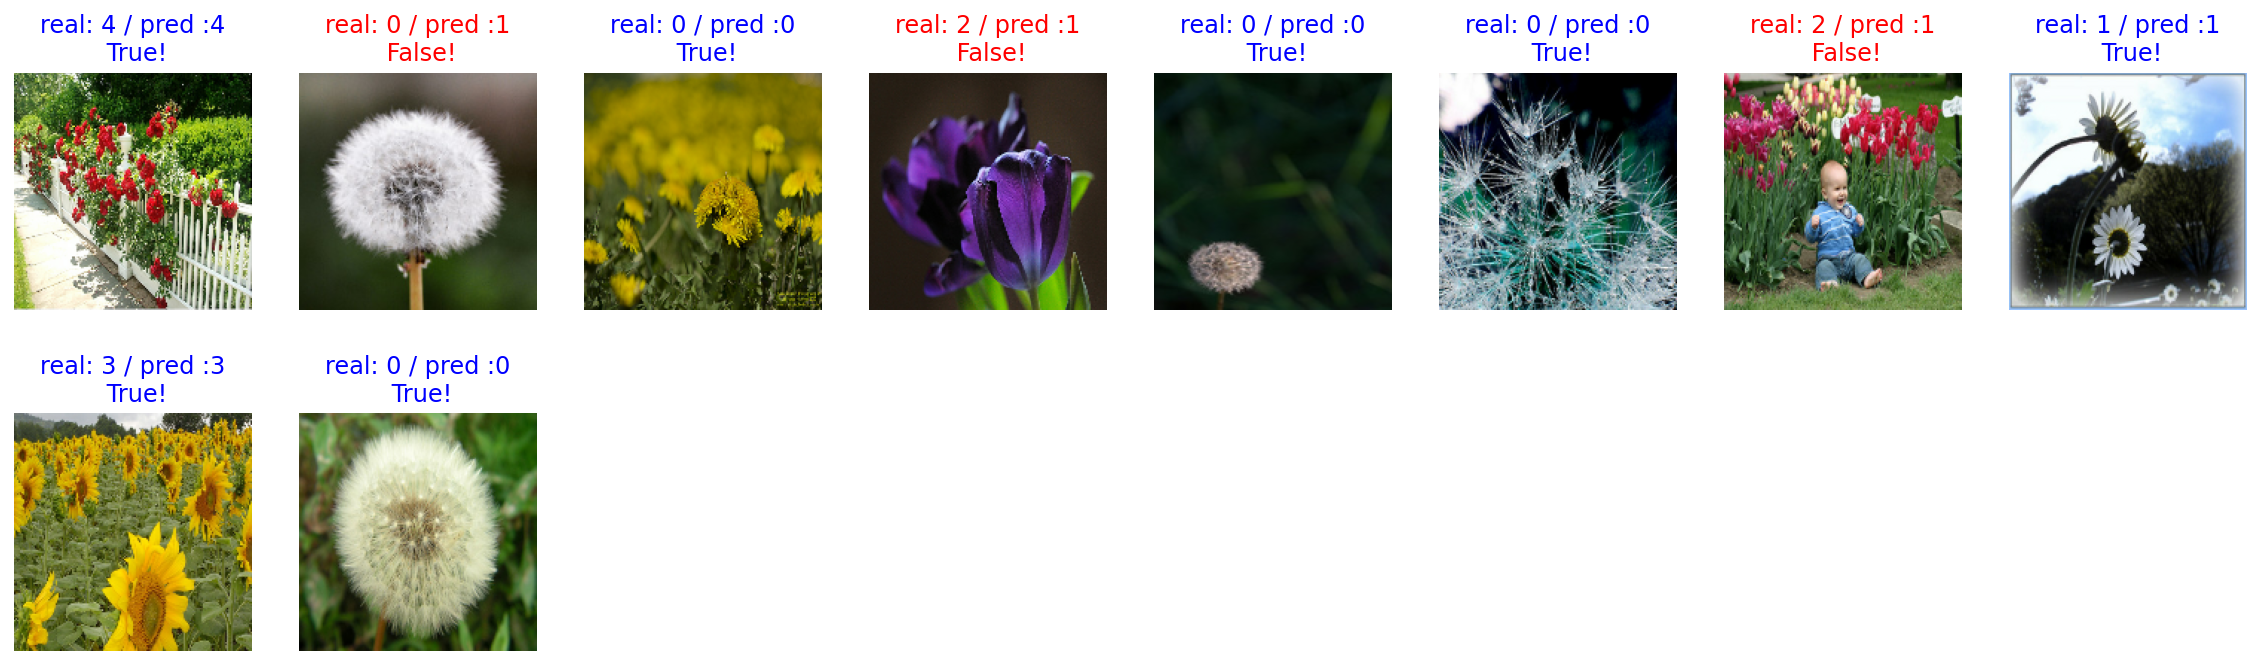

In [21]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [22]:
# 정답을 맞춘 개수
count = 0   
total = 0
for image, label, prediction in zip(images, labels, predictions):
    total +=1
    correct = label == prediction
    if correct:
        count = count +1


print(count / total * 100)

70.0


### 모델 튜닝

In [23]:
#사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [24]:
image_batch.shape

TensorShape([10, 160, 160, 3])

In [25]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([10, 5, 5, 512])

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 512)


In [28]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(10, 5)


In [29]:
base_model.trainable = False

In [30]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
# VGG16을 기반으로 구성된 이미지 분류기를 학습시키고, 직접 만들었던 모델과 결과 비교

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 27ms/step - loss: 1.6512 - accuracy: 0.2650
initial loss: 1.65
initial accuracy: 0.26


In [32]:
EPOCHS = 5  

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
294/294 [==============================] - 46s 156ms/step - loss: 1.2053 - accuracy: 0.5855 - val_loss: 0.9274 - val_accuracy: 0.6948
Epoch 2/5
294/294 [==============================] - 10s 33ms/step - loss: 0.8277 - accuracy: 0.7422 - val_loss: 0.7263 - val_accuracy: 0.7520
Epoch 3/5
294/294 [==============================] - 10s 33ms/step - loss: 0.6908 - accuracy: 0.7721 - val_loss: 0.6443 - val_accuracy: 0.7875
Epoch 4/5
294/294 [==============================] - 10s 33ms/step - loss: 0.6168 - accuracy: 0.7987 - val_loss: 0.6053 - val_accuracy: 0.7902
Epoch 5/5
294/294 [==============================] - 10s 33ms/step - loss: 0.5674 - accuracy: 0.8168 - val_loss: 0.5575 - val_accuracy: 0.7956


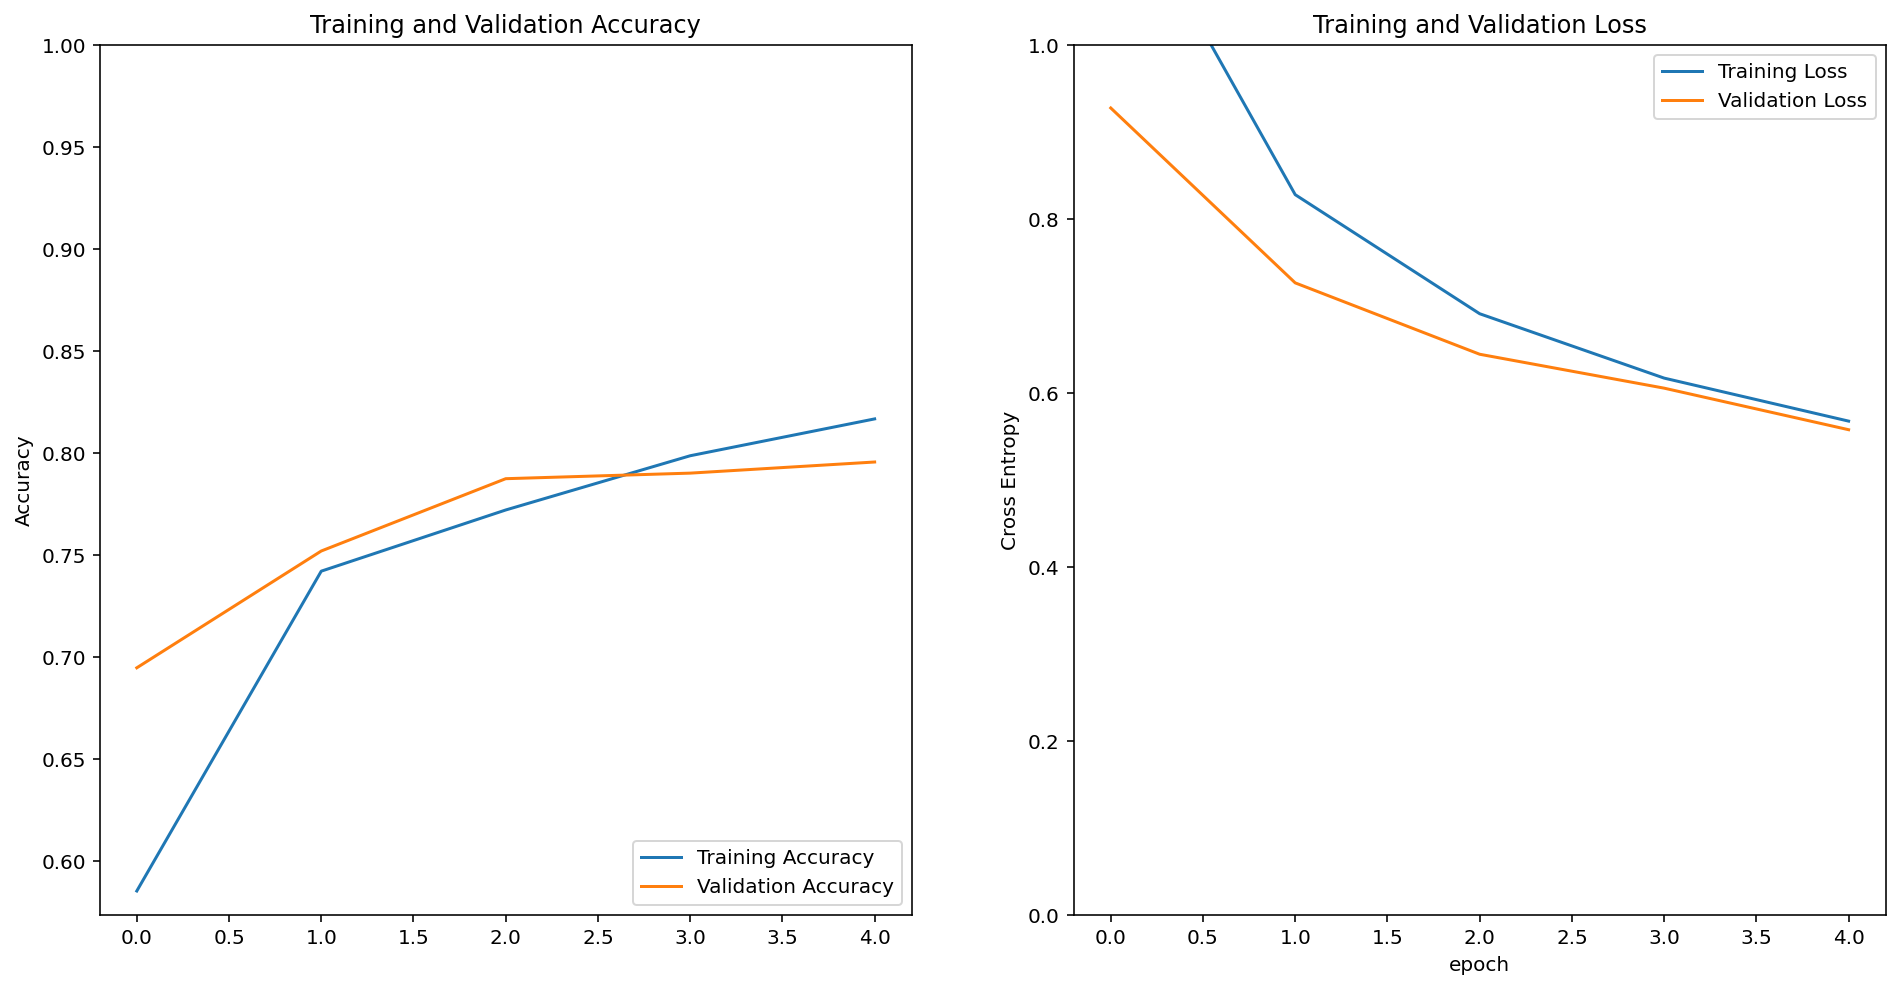

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.90535893e-02, 6.63707927e-02, 7.25290716e-01, 6.05779141e-02,
        1.18706986e-01],
       [9.98519838e-01, 1.16231712e-03, 1.88311096e-05, 1.95124230e-04,
        1.03864681e-04],
       [7.76484787e-01, 1.02000564e-01, 2.57447176e-02, 7.45195523e-02,
        2.12504007e-02],
       [3.57715087e-03, 2.31237467e-02, 5.11185944e-01, 1.27265109e-02,
        4.49386656e-01],
       [6.80596828e-01, 2.59405613e-01, 1.85321923e-02, 1.44948196e-02,
        2.69705728e-02],
       [9.12378609e-01, 5.17171659e-02, 6.81760162e-03, 2.67480686e-02,
        2.33848719e-03],
       [1.19835855e-02, 1.57756545e-02, 7.49512911e-01, 1.38731077e-01,
        8.39967206e-02],
       [4.09096152e-01, 4.04811025e-01, 3.13861901e-03, 1.75180703e-01,
        7.77357258e-03],
       [1.52329011e-02, 2.93112500e-03, 3.72479968e-02, 8.11922967e-01,
        1.32665008e-01],
       [9.99356329e-01, 5.23538562e-04, 2.51754477e-06, 1.12056943e-04,
        5.43867554e-06]], dtype=float32)

In [35]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 0, 3, 0])

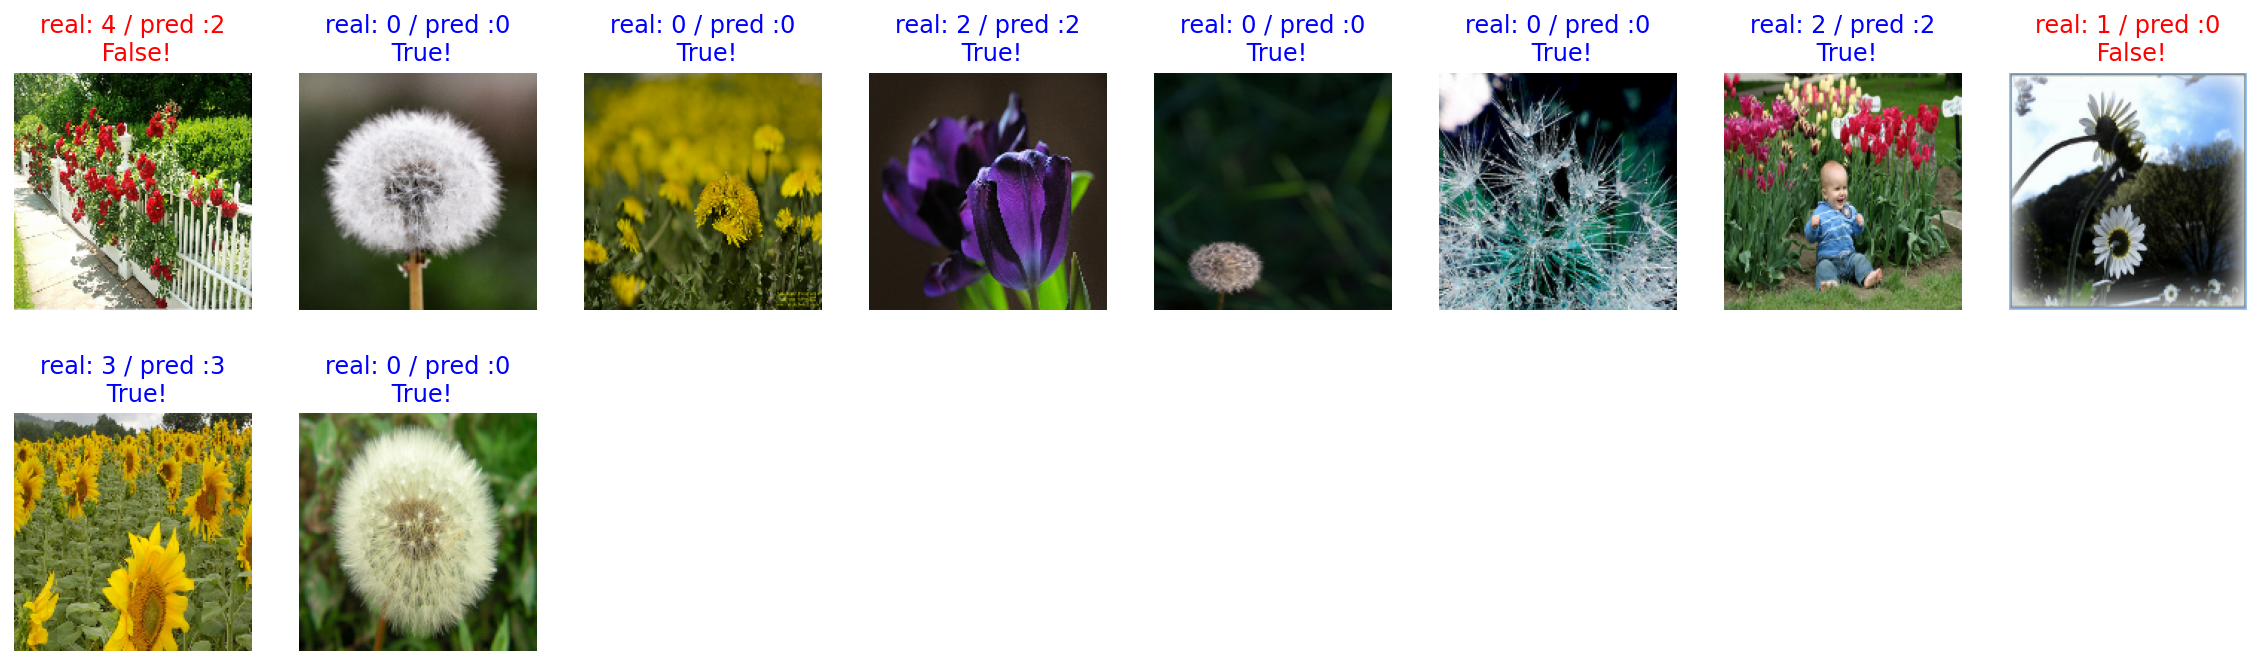

In [36]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [37]:
count = 0   
total = 0
for image, label, prediction in zip(images, labels, predictions):
    total +=1
    correct = label == prediction
    if correct:
        count = count +1


print(count / total * 100)

80.0


In [38]:
# MobileNet

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model
base_model = tf.keras.applications.MobileNet( input_shape=IMG_SHAPE, alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=False, weights='imagenet', input_tensor=None, pooling=None,
    classes=5, classifier_activation='softmax')


In [39]:
image_batch.shape

TensorShape([10, 160, 160, 3])

In [40]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([10, 5, 5, 1024])

In [41]:
base_model.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32) 

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1024)


In [43]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')


prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(10, 5)


In [44]:
base_model.trainable = False

In [45]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 3,756,229
Trainable params: 527,365
Non-trainable params: 3,228,864
_________________________________________________________________


In [46]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 6ms/step - loss: 1.8162 - accuracy: 0.2500
initial loss: 1.82
initial accuracy: 0.25


In [47]:
EPOCHS = 5  

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
294/294 [==============================] - 32s 110ms/step - loss: 0.5803 - accuracy: 0.7933 - val_loss: 0.3749 - val_accuracy: 0.8747
Epoch 2/5
294/294 [==============================] - 3s 9ms/step - loss: 0.2638 - accuracy: 0.9087 - val_loss: 0.3302 - val_accuracy: 0.8828
Epoch 3/5
294/294 [==============================] - 3s 10ms/step - loss: 0.1757 - accuracy: 0.9414 - val_loss: 0.3370 - val_accuracy: 0.8856
Epoch 4/5
294/294 [==============================] - 3s 9ms/step - loss: 0.1197 - accuracy: 0.9615 - val_loss: 0.3293 - val_accuracy: 0.8801
Epoch 5/5
294/294 [==============================] - 3s 9ms/step - loss: 0.0909 - accuracy: 0.9745 - val_loss: 0.2892 - val_accuracy: 0.9046


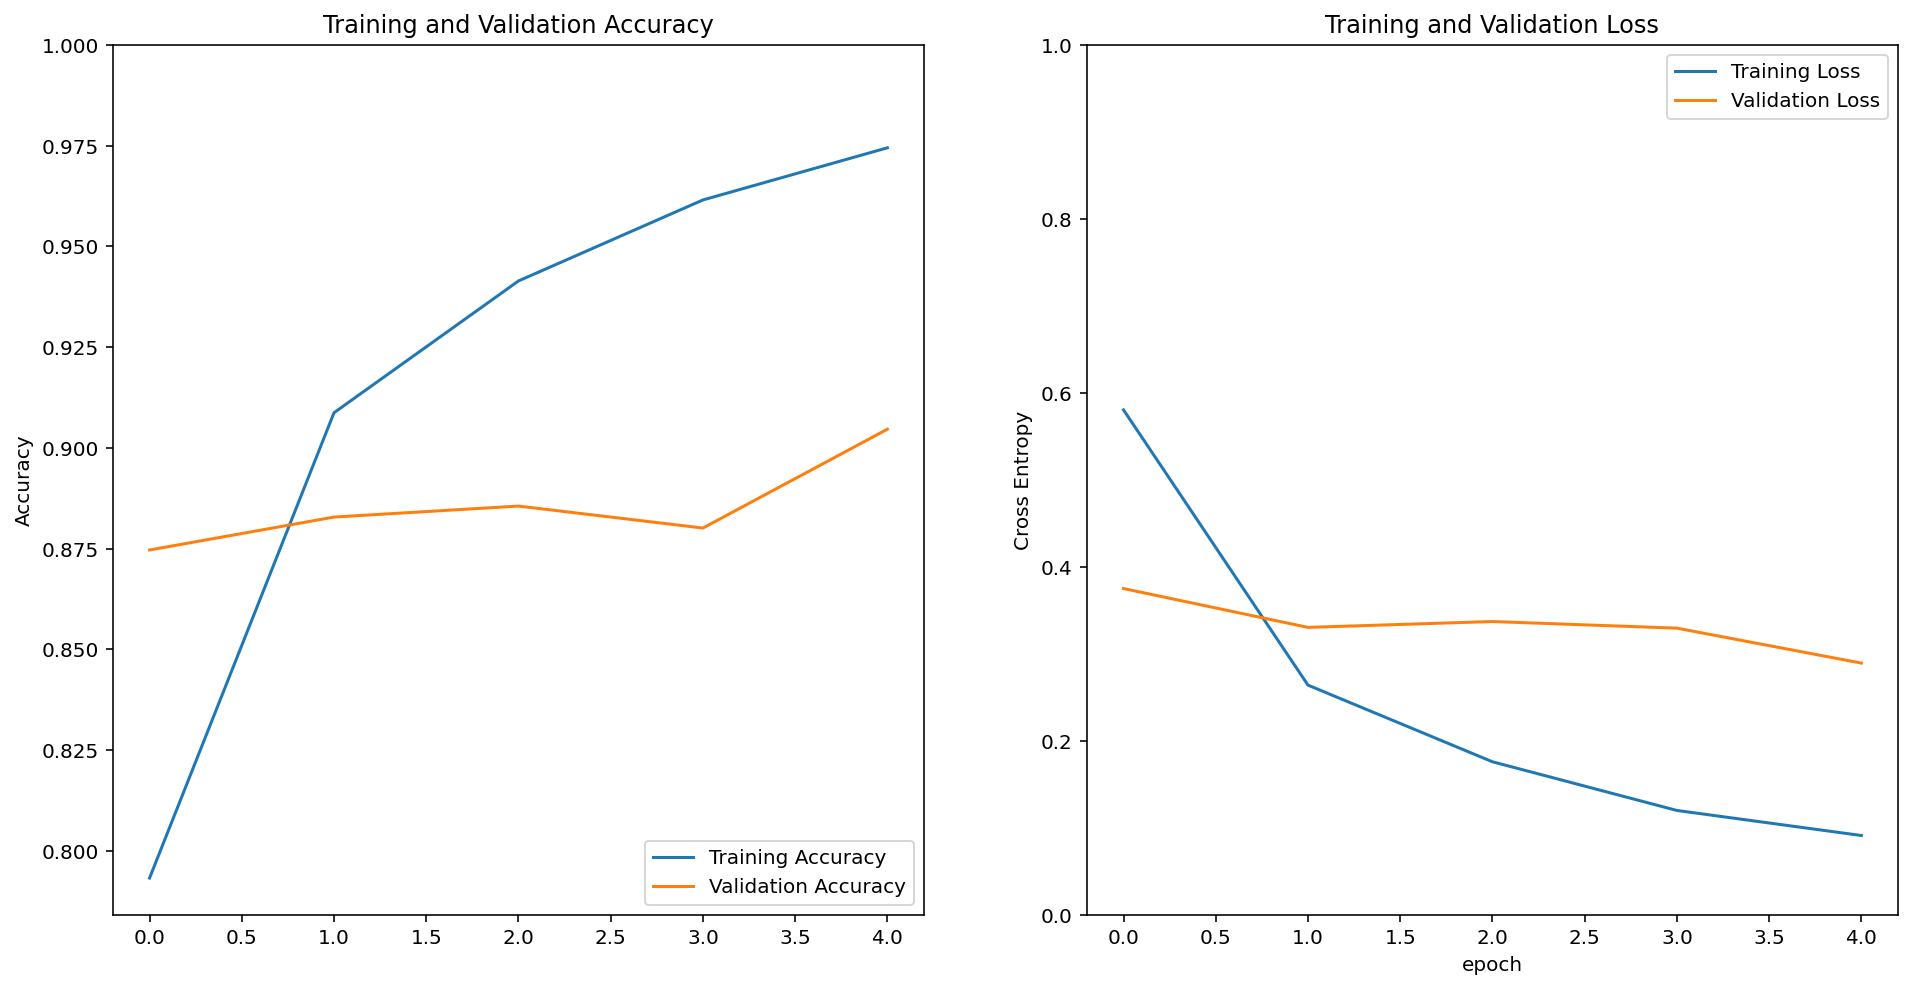

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.7160672e-04, 4.4750172e-04, 9.7227162e-01, 2.3366505e-02,
        3.7426967e-03],
       [9.9999845e-01, 1.4210822e-06, 5.2533654e-08, 6.5575105e-09,
        7.0121168e-08],
       [9.8302263e-01, 3.4543620e-05, 5.3055985e-05, 1.6654950e-02,
        2.3480074e-04],
       [4.4881475e-05, 5.8439566e-04, 9.8138118e-01, 9.0316677e-04,
        1.7086333e-02],
       [9.9567682e-01, 3.7252728e-03, 6.3461557e-05, 3.7171511e-04,
        1.6278353e-04],
       [9.9961412e-01, 2.1401254e-04, 1.0567911e-04, 6.4815336e-05,
        1.3455933e-06],
       [5.2208977e-04, 3.1505009e-05, 9.9694246e-01, 2.1457511e-03,
        3.5818358e-04],
       [6.8564139e-02, 4.9694598e-01, 1.1146208e-05, 4.3432990e-01,
        1.4878159e-04],
       [1.1637663e-03, 1.2366010e-07, 4.6620544e-02, 9.5181292e-01,
        4.0254812e-04],
       [9.9992073e-01, 4.3462103e-05, 3.0163426e-05, 3.5921369e-06,
        2.0311491e-06]], dtype=float32)

In [50]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0])

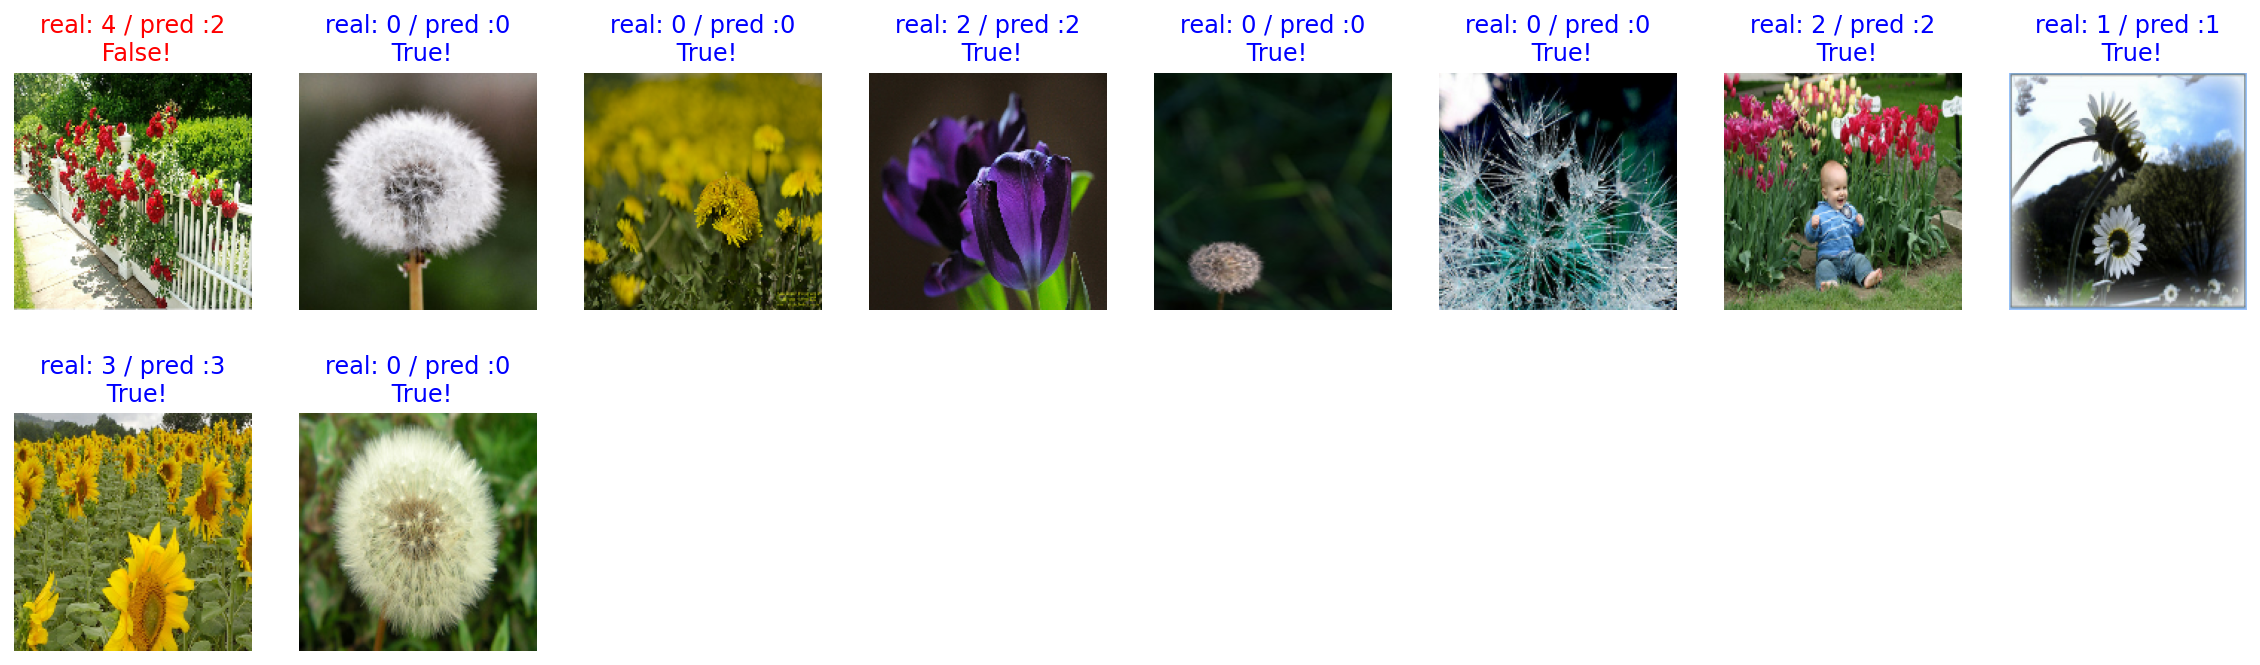

In [51]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [52]:
count = 0   
total = 0
for image, label, prediction in zip(images, labels, predictions):
    total +=1
    correct = label == prediction
    if correct:
        count = count +1


print(count / total * 100)

90.0


In [53]:
# checkpoint 파일 생성
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/flower/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [54]:
#학습된 모델에 원하는 이미지를 입력해 예측 결과 확인해 보기

img_dir_path = os.getenv("HOME") + "/aiffel/flower/images"
os.path.exists(img_dir_path)

True

In [55]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [56]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulips_percentage}% tulips, {sunflowers_percentage}% sunflowers, and {roses_percentage}% roses.")

This image seems 15.0% dandelion, 0.0% daisy, 49.0% tulips, 0.0% sunflowers, and 36.0% roses.


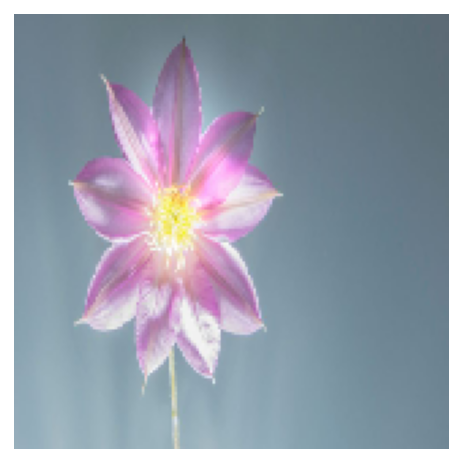

In [57]:
filename = 'flower.jpeg'

show_and_predict_image(img_dir_path, filename)

초기 만든 모델과, VGG16, MobileNet 모델을 사용해보았다.

초기 모델과 Vgg16은 기존 노드에서 따라한 방법대로 그대로 따라해서 하기 쉬웠는데,
다른 모델로 바꾸려고 해보니 옵션에서 어떠한 것을 바꿔야 할 지, 고민이 생겼다. 

tf.keras.applications.MobileNet(
    input_shape=None, alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=True, weights='imagenet', input_tensor=None, pooling=None,
    classes=1000, classifier_activation='softmax', **kwargs)
    
input_shape=IMG_SHAPE
include_top=False
classes=5
로 바꾸고,

**kwargs    를 삭제하니, 돌아갔다..!!!, 얘가 무슨 기능을 하는지는 모르겠다.

Vgg16의 그래프가 안정적으로 보였는데, 정확도에선 MobileNet이 90%으로 더 높았다.
MobileNet의 summary를 보니 층이 깊다고 표현해야 하나, 제일 길었다. 그래서 정확도가 올라갔나..?

여기 주피터노트북에는 올려져있지 않지만, ResNet50 모델도 돌려보았으나, 정확도가 50%으로 제일 낮았고,
한 주피터노트북에서 여러 모델을 돌리다보니 에러가 많이나서, 터미널 종료했다가 다시 실행하고, 노트북이 고생많았다...

시간과 여력이 된다면 다른 모델들도 돌려보고 싶다. 우선 돌려본 모델만으로 선택을 하라면, 정확도가 높게 나온 MobileNet으로..!